In [127]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
import data_util  
from datetime import datetime
import copy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler



In [128]:
from Evaluation_metrics import *
def evaluate_metrics(y_true, y_pred):
    results = {
        'Metric': ['MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'SMAPE'],
        'Value': [MAPE(y_true, y_pred), 
                  MAE(y_true, y_pred), 
                  MSE(y_true, y_pred), 
                  RMSE(y_true, y_pred), 
                  R2(y_true, y_pred), 
                  SMAPE(y_true, y_pred)]
    }
    df = pd.DataFrame(results)
    
    # Add dotted lines
    dotted_style = [dict(selector="th", props=[("border-bottom", "1px dotted #aaaaaa")]),
                    dict(selector="td", props=[("border-bottom", "1px dotted #aaaaaa")])]
    
    # Apply styling
    styled_df = (df.style
                 .set_properties(**{'text-align': 'center'})
                 .format({'Value': '{:.2f}'})  # Round values to 2 decimal places
                 .set_table_styles(dotted_style)
                 .set_caption('Evaluation Metrics')
                 .set_table_attributes('style="border-collapse: collapse; border: none;"')
                 .set_properties(subset=['Metric'], **{'font-weight': 'bold',}))  # Bold and blue headers
    
    return styled_df

from keras.callbacks import Callback

# Custom callback to display output every 'n' epochs
class VerboseEveryN(Callback):
    def __init__(self, n=5):
        super(VerboseEveryN, self).__init__()
        self.n = n

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            print(f"Epoch {epoch+1} - {logs}")

In [129]:
def split_data(data,percent_split):
    size=(int((np.shape(data)[0])*(percent_split/100)))
    return data[0:size], data[size:]

	
# train_data,test_data=split_data(data, 70)

def create_dataset(data, step):
	X, Y = list(), list()

	for i in range(len(data)-step-1):
		X.append(data[i:(i+step), 0])
		Y.append(data[i + step, 0])
	return np.array(X), np.array(Y)

def make_model(step ,numOfStacks, num_neurons):
    model=Sequential()
    model.add(LSTM(num_neurons[0],return_sequences=True,input_shape=(step,1)))
    for i in range(1,numOfStacks-1):
        model.add(LSTM(num_neurons[i],return_sequences=True))
    model.add(LSTM(num_neurons[-1]))
    
    model.add(Dense(1))
    return model

In [130]:
from keras.callbacks import Callback

# Custom callback to display output every 'n' epochs
class VerboseEveryN(Callback):
    def __init__(self, n=5):
        super(VerboseEveryN, self).__init__()
        self.n = n

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            print(f"Epoch {epoch+1} - {logs}")

In [131]:
def Lstm(stock,epochs=10,step=100,numOfStacks=3,num_neurons=[64,64,50]):
    fit=MinMaxScaler(feature_range=(0,1))
    unscaled_data=np.array(list(stock['Close']))
    data=fit.fit_transform(np.array(list(stock['Close'])).reshape(-1,1))
    train_data,test_data=split_data(data, 70)
    # step = 100
    x_train, y_train = create_dataset(train_data, step)
    x_test, y_test = create_dataset(test_data, step)
    #1 is representing the number of features we are using , here we are doing univariate LSTM . Therefore , 1
    x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

    # numOfStacks=3
    # num_neurons=[64,64,50]
    model=make_model(step , numOfStacks,num_neurons)
    model.compile(loss='mean_squared_error',optimizer='adam')
    # model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=epochs,batch_size=64,verbose=2)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=64, verbose=0, callbacks=[VerboseEveryN(epochs/10)])
    train_predict=model.predict(x_train)
    test_predict=model.predict(x_test)    

    train_predict=fit.inverse_transform(train_predict)
    test_predict=fit.inverse_transform(test_predict)
    y_test=fit.inverse_transform(y_test.reshape(-1,1))
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(step*2)+1:len(data)-1] = test_predict
    # Plot the actual data in blue and the predicted data in red
    plt.plot(unscaled_data[:len(train_data)+len(unscaled_data)-len(test_predict)-len(train_data)], color='blue', label='Train Data Price')
    plt.plot(range(len(train_data)+len(unscaled_data)-len(test_predict)-len(train_data),len(unscaled_data)),unscaled_data[len(train_data)+len(unscaled_data)-len(test_predict)-len(train_data):], color='red', label='Test data Price')
    plt.plot(testPredictPlot, color='orange', label='Predicted Price')
    plt.legend()
    plt.show()

    # print(test_predict.shape, y_test.shape)
    return test_predict,y_test
# need to add avaluation metrics here


[*********************100%%**********************]  1 of 1 completed


Epoch 1 - {'loss': 0.10384805500507355, 'val_loss': 0.012013942934572697}
Epoch 11 - {'loss': 0.0030523333698511124, 'val_loss': 0.0031268529128283262}
Epoch 21 - {'loss': 0.0025057417806237936, 'val_loss': 0.0038242570590227842}
Epoch 31 - {'loss': 0.001984133617952466, 'val_loss': 0.003618714166805148}
Epoch 41 - {'loss': 0.0016215085051953793, 'val_loss': 0.0025132859591394663}
Epoch 51 - {'loss': 0.0014845123514533043, 'val_loss': 0.0013285486493259668}
Epoch 61 - {'loss': 0.0011702568735927343, 'val_loss': 0.0012391956988722086}
Epoch 71 - {'loss': 0.0011703054187819362, 'val_loss': 0.0012411075877025723}
Epoch 81 - {'loss': 0.0009520062012597919, 'val_loss': 0.0007669118931517005}
Epoch 91 - {'loss': 0.0010615367209538817, 'val_loss': 0.0006605075905099511}
7/7 [==============================] - 0s 44ms/step


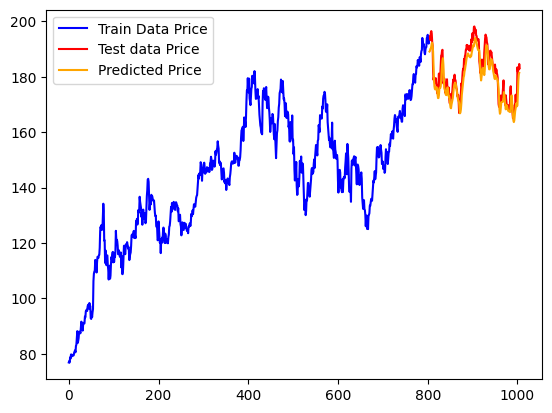

,Metric,Value
0,MAPE,1.73
1,MAE,3.15
2,MSE,14.81
3,RMSE,3.85
4,R2,0.80
5,SMAPE,1.74


In [132]:
a_stocks=data_util.stock_data('AAPL', 4,'Apple')
y_pred,y_true=Lstm(a_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

[*********************100%%**********************]  1 of 1 completed


Epoch 1 - {'loss': 0.05659189447760582, 'val_loss': 0.05517638474702835}
Epoch 11 - {'loss': 0.00244215689599514, 'val_loss': 0.002629210939630866}
Epoch 21 - {'loss': 0.002136996714398265, 'val_loss': 0.003264500992372632}
Epoch 31 - {'loss': 0.001818405115045607, 'val_loss': 0.0012028657365590334}
Epoch 41 - {'loss': 0.0017613981617614627, 'val_loss': 0.0020705237984657288}
Epoch 51 - {'loss': 0.0012811560882255435, 'val_loss': 0.0009862941224128008}
Epoch 61 - {'loss': 0.0012026069452986121, 'val_loss': 0.0009174270089715719}
Epoch 71 - {'loss': 0.0009909223299473524, 'val_loss': 0.0005836687632836401}
Epoch 81 - {'loss': 0.0009047116036526859, 'val_loss': 0.0007205669535323977}
Epoch 91 - {'loss': 0.0010396904544904828, 'val_loss': 0.001019611256197095}
7/7 [==============================] - 0s 39ms/step


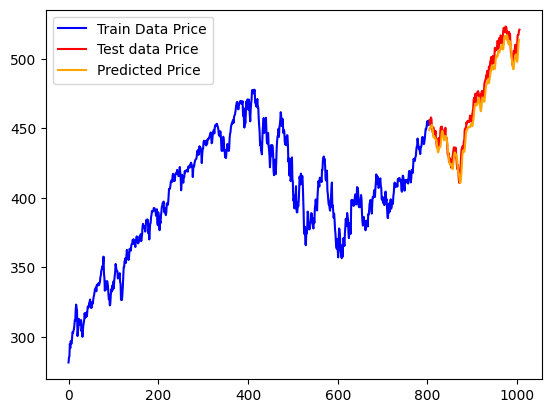

,Metric,Value
0,MAPE,1.21
1,MAE,5.74
2,MSE,46.13
3,RMSE,6.79
4,R2,0.96
5,SMAPE,1.22


In [133]:
s_stocks=data_util.stock_data('SPY', 4,'SPY')
y_pred,y_true=Lstm(s_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

[*********************100%%**********************]  1 of 1 completed


Epoch 1 - {'loss': 0.08392027020454407, 'val_loss': 0.03123088739812374}
Epoch 11 - {'loss': 0.001031826832331717, 'val_loss': 0.006312054116278887}
Epoch 21 - {'loss': 0.0009412059444002807, 'val_loss': 0.0024616278242319822}
Epoch 31 - {'loss': 0.0008261127513833344, 'val_loss': 0.003891536733135581}
Epoch 41 - {'loss': 0.0007726717158220708, 'val_loss': 0.002990465611219406}
Epoch 51 - {'loss': 0.0007016543531790376, 'val_loss': 0.0005962778814136982}
Epoch 61 - {'loss': 0.0006410083151422441, 'val_loss': 0.002046820241957903}
Epoch 71 - {'loss': 0.000570848525967449, 'val_loss': 0.0007299481076188385}
Epoch 81 - {'loss': 0.0004785141791217029, 'val_loss': 0.0012818981194868684}
Epoch 91 - {'loss': 0.0004465650417841971, 'val_loss': 0.0005544990999624133}
7/7 [==============================] - 0s 34ms/step


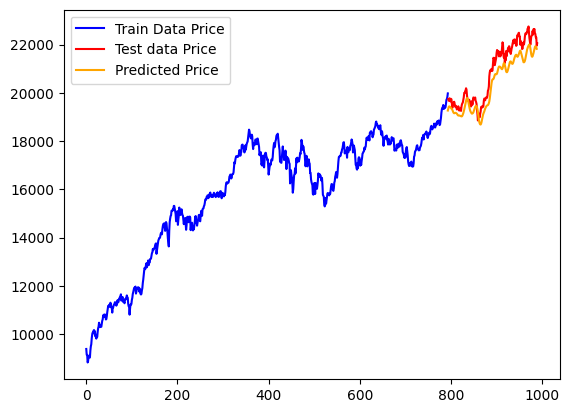

,Metric,Value
0,MAPE,2.47
1,MAE,521.29
2,MSE,336281.50
3,RMSE,579.90
4,R2,0.77
5,SMAPE,2.50


In [134]:
n_stocks=data_util.stock_data('^NSEI', 4,'Nifty 50')
y_pred,y_true=Lstm(n_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

[*********************100%%**********************]  1 of 1 completed


Epoch 1 - {'loss': 0.1243443563580513, 'val_loss': 0.00169298704713583}
Epoch 11 - {'loss': 0.002751449355855584, 'val_loss': 0.001328868675045669}
Epoch 21 - {'loss': 0.002078849356621504, 'val_loss': 0.0008212198736146092}
Epoch 31 - {'loss': 0.0016856013098731637, 'val_loss': 0.0007613189518451691}
Epoch 41 - {'loss': 0.0015508981887251139, 'val_loss': 0.0006762255798093975}
Epoch 51 - {'loss': 0.0012239522766321898, 'val_loss': 0.0007191603654064238}
Epoch 61 - {'loss': 0.001026613055728376, 'val_loss': 0.0006666842382401228}
Epoch 71 - {'loss': 0.0008621562737971544, 'val_loss': 0.0004693603841587901}
Epoch 81 - {'loss': 0.0007900390774011612, 'val_loss': 0.000739673909265548}
Epoch 91 - {'loss': 0.0007319618598558009, 'val_loss': 0.0003569398249965161}
7/7 [==============================] - 0s 39ms/step


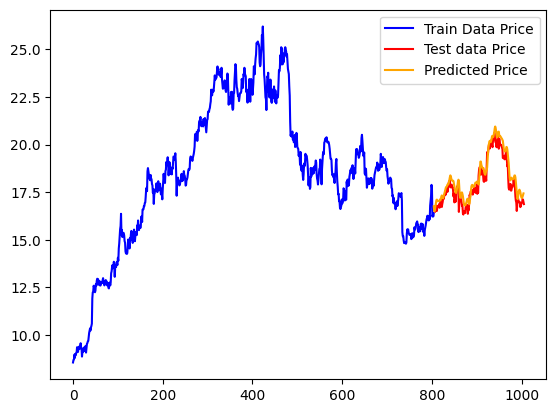

,Metric,Value
0,MAPE,2.17
1,MAE,0.39
2,MSE,0.22
3,RMSE,0.47
4,R2,0.84
5,SMAPE,2.14


In [135]:
i_stocks=data_util.stock_data('INFY', 4,'Infosys')
y_pred,y_true=Lstm(i_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df